This notebook contains the code used in the article

 "**Solving Neural Field Equations using Physics Informed Neural Networks**"

 by W. Wojtak et al, accepted for the ICNAAM 2023 conference.

 If you use this code, please cite:

```
@inproceedings{wojtak2023,
  title={Solving Neural Field Equations using Physics Informed Neural Networks},
  author={Wojtak, W. and Bicho, E. and Erlhagen, W.},
  booktitle={21st International Conference of Numerical Analysis and Applied Mathematics, ICNAAM 2023},
  year={2023}
}
```

It is the PyTorch code adapted from:
L. Yuan, Y.-Q. Ni, X.-Y. Deng, and S. Hao, “A-PINN: Auxiliary physics informed neural networks for forward and inverse problems of nonlinear  integro-differential equations,” Journal of Computational Physics 462, 111260 (2022)

available at: https://github.com/YUANLei2021/A-PINN








In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import datetime
import torch.nn as fun
import os
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

0:00:00.010900
0:00:00.009596
L2 error:  0.0037608142534908814


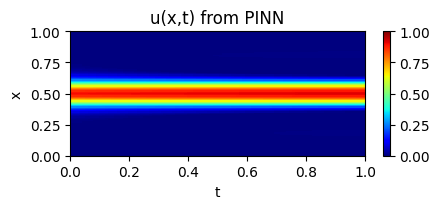

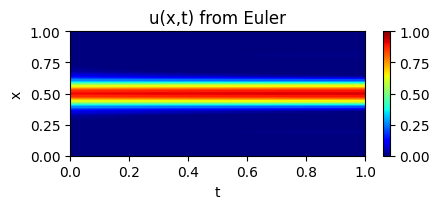

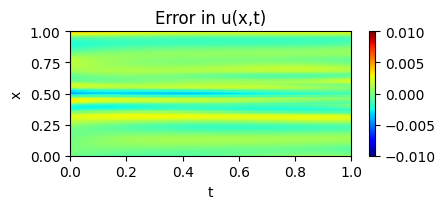

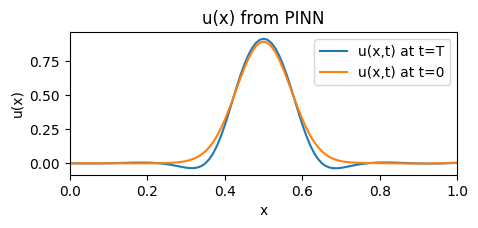

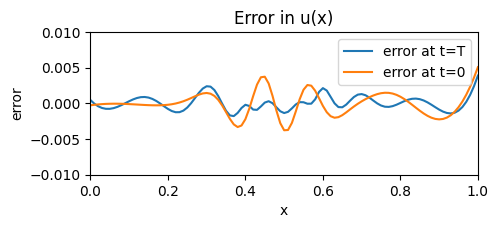

In [ ]:
def main():
    #  pde parameters
    lam = [1.0, 1.0]
    x_range = [0, 1]
    t_range = [0.0, 1.0]
    pde_parameters = [lam, x_range, t_range]

    # train parameters
    ni = 500
    optimizer = 0  # 0: L-BFGS 1: Adam 2: SGD
    max_iter = 501
    min_loss = 1e-8
    learning_rate = 0.01
    process = True
    train_parameters = [ni, optimizer, max_iter, min_loss, learning_rate, process]

    # test parameters
    dx = 0.01
    dt = 0.01
    test_parameters = [dx, dt]

    # Neural networks parameters
    nn_layers = [2, 40, 40, 1]  # neural networks layers
    act_fun = 0  # 0: fun.Tanh(), 1: fun.Sigmoid(), 2: fun.ReLU(), 3: Sin()
    nn_parameters = [nn_layers, act_fun]

    dirs = ['./model', './data', './png']
    for dir in dirs:
        if not os.path.exists(dir):
            os.makedirs(dir)

    # train(pde_parameters, train_parameters, nn_parameters)  # train nn model
    test(pde_parameters, test_parameters)



class Net(torch.nn.Module):
    def __init__(self, parameters):
        [nn_layers, act_fun] = parameters
        af_list = {
            0: fun.Tanh(),
            1: fun.Sigmoid(),
            2: fun.ReLU(),
            3: Sin()
        }
        activation_function = af_list.get(act_fun, None)
        super(Net, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(nn_layers)-2):
            self.layers.append(torch.nn.Linear(nn_layers[i], nn_layers[i + 1]),)
            self.layers.append(activation_function)
        self.layers.append(torch.nn.Linear(nn_layers[-2], nn_layers[-1]),)

    def forward(self, x):
        for m in self.layers:
            x = m(x)
        return x


class Sin(torch.nn.Module):
    @staticmethod
    def forward(x):
        return torch.sin(x)


def pred(net_model, x, t, x_range, t_range):
    x_lb = x_range[0]
    x_ub = x_range[1]
    x_ = 2.0 * (x - x_lb) / (x_ub - x_lb) - 1.0
    t_lb = t_range[0]
    t_ub = t_range[1]
    t_ = 2.0 * (t - t_lb) / (t_ub - t_lb) - 1.0
    model_return = net_model(torch.cat((x_, t_), 1))
    u = model_return
    return u


def kernel(x, A, b, c):
    return A * np.exp(-b*np.abs(c*(x-0.5)))*((b*np.sin(np.abs(c*(x-0.5))))+np.cos(c*(x-0.5)))


def sigmoid(u, beta, theta):
    return 1 / (1 + torch.exp(-beta * (u - theta)))


def train(pde_parameters, train_parameters, nn_parameters):
    # loading parameters
    [ni, opt, max_iter, min_loss, learning_rate, process] = train_parameters
    [_, x_range, t_range] = pde_parameters
    # choose device to train the model
#     device = 'cuda'
    device = 'cpu'
    t_i = torch.FloatTensor(np.ones([ni, 1]) * t_range[0]).to(device)  # initial t value
    x_i = torch.FloatTensor(np.linspace(x_range[0], x_range[1], ni, endpoint=True).reshape(-1, 1)).to(device)

    x_exact = np.arange(x_range[0], x_range[1], 1e-2)
    t_exact = np.arange(t_range[0], t_range[1], 1e-2)
    x_e_mesh, t_e_mesh = np.meshgrid(x_exact, t_exact)
    t_e = t_e_mesh.flatten()
    x_e = x_e_mesh.flatten()

    t_star = t_e.reshape(-1, 1)
    t_f = torch.FloatTensor(t_star).to(device)
    x_star = x_e.reshape(-1, 1)
    x_f = torch.FloatTensor(x_star).to(device)

    # dynamic display during training
    x_test = np.linspace(x_range[0], x_range[1], 100)
    t_test = np.linspace(t_range[0], t_range[1], 100)
    t_mesh, x_mesh = np.meshgrid(t_test, x_test)
    tx_shape = np.shape(x_mesh)
    x_test_ts = torch.FloatTensor(x_mesh.flatten()[:, None]).to(device)
    t_test_ts = torch.FloatTensor(t_mesh.flatten()[:, None]).to(device)

    # NFE parameters
    A, b, c = 10, 0.7, 24
    theta, beta = .4, 100
    half_L = 0.5

    # loading initial condition
    u_i = 0.9 * torch.exp(-0.5 * (x_i-0.5) ** 2 / 0.07 ** 2)
    w_x_exact = kernel(x_exact, A, b, c)
    w_hat_exact = torch.fft.fft(torch.FloatTensor(w_x_exact)).to(device)

    # set x t require grad
    x_i.requires_grad = True
    t_i.requires_grad = True
    t_f.requires_grad = True
    x_f.requires_grad = True
    # initialize neural networks and optimizer
    net_model = Net(nn_parameters).to(device)
    # choose optimizer
    if opt == 1:
        optimizer = torch.optim.Adam([{'params': net_model.parameters()}], lr=learning_rate)
    elif opt == 2:
        optimizer = torch.optim.SGD([{'params': net_model.parameters()}], lr=learning_rate)
    else:
        optimizer = torch.optim.LBFGS([{'params': net_model.parameters()}], lr=learning_rate)
    # set loss function
    loss_func = torch.nn.MSELoss().to(device)

    it = 0
    loss = 10
    loss_record = np.empty([0, 3])
    plt.ion()
    print('------------------------Neural networks------------------------------------')
    print(net_model)
    print('----------------------------Optimizer--------------------------------------')
    print(optimizer)
    print('------------------------Training device: ', device, '-----------------------------')
    #  -----------   start training  ------------
    starttime_train = datetime.datetime.now()
    print('------------------------Start training:{}---------------------'.format(starttime_train))


    while it < max_iter and loss > min_loss:
        def closure():
            u_i_pred = pred(net_model, x_i, t_i, x_range, t_range)
            u_f_pred = pred(net_model, x_f, t_f, x_range, t_range)
            u_f_pred_dt = torch.autograd.grad(u_f_pred.sum(), t_f, create_graph=True)[0]

            u_f =  (torch.reshape(u_f_pred, (100, 100)))

            conv_int = torch.zeros_like(u_f)

            for i in range(0, w_hat_exact.size()[0]):
                f_hat = torch.fft.fft(1 / (1 + torch.exp(-beta * (u_f[i,:] - theta))))
                conv_int[i,:] = 1e-2 * torch.fft.ifftshift(torch.real(torch.fft.ifft(w_hat_exact * f_hat)))

            conv_int = torch.reshape(conv_int, (10000, 1))

            f = - u_f_pred_dt - u_f_pred + conv_int.float()

            loss_0 = loss_func(u_i_pred, u_i)

            loss_f = loss_func(f, torch.zeros_like(t_f)).float()

            loss_all = np.array((loss_0.data.cpu().numpy(), loss_f.data.cpu().numpy()))

            loss_min = np.min(loss_all)
            loss_all = loss_all / loss_min
            loss_all[loss_all > 100] = 100.0
            loss_weight = loss_all

            loss_total = loss_weight[0] * loss_0 + loss_weight[1] * loss_f
            loss_total = loss_total.float()

            optimizer.zero_grad()
            loss_total.backward(retain_graph=True)
            return loss_total

        optimizer.step(closure)
        loss_value = closure().cpu().data.numpy()
        step_time = datetime.datetime.now() - starttime_train
        loss_record = np.append(loss_record, [[it, step_time.seconds + step_time.microseconds / 1000000, loss_value]],
                                axis=0)

        if it % 100 == 0:
            print('Running: ', it, ' / ', max_iter)
            if process:

                u_test_pred = pred(net_model, x_test_ts, t_test_ts, x_range, t_range)
                u_test_pred = u_test_pred.data.cpu().numpy().reshape(tx_shape)

                f = plt.figure(figsize=(15, 4))
                ax = f.add_subplot(121)
                ax2 = f.add_subplot(122)

                ax.plot(x_test, u_test_pred[:, 99], label='u(x,t) at t=end')
                ax.plot(x_test, u_test_pred[:, 0], label='u(x,t) at t=0')
                ax.set_xlabel('x')
                ax.set_ylabel('u(x)')

                ax.legend(loc='upper right')

                pic = plt.imshow(u_test_pred, cmap='jet', vmin=-1.0, vmax=1.0,
                                 extent=[t_range[0], t_range[1], x_range[0], x_range[1]],
                                 interpolation='nearest', origin='lower', aspect='auto')
                plt.colorbar(pic)
                plt.scatter(t_star, x_star, label='Collocation points', s=1.0, c='k', marker='.')
                plt.xlim(t_range[0], t_range[1])
                plt.ylim(x_range[0], x_range[1])
                plt.legend(loc='upper right')
                ax2.set_xlabel('t')
                ax2.set_ylabel('u')
                plt.pause(0.01)
                plt.show()


        it = it + 1
    endtime_train = datetime.datetime.now()
    print('---------------End training:{}---------------'.format(endtime_train))
    torch.save(net_model, './model/PINN_NFE.pkl')
    np.savetxt('./data/PINN_NFE-loss.txt', loss_record)

    train_time = endtime_train - starttime_train
    print('---------------Training time:{}s---------------'.format(train_time.seconds + train_time.microseconds / 1e6))

    plt.ioff()
    plt.show()

    plt.figure()
    plt.plot(loss_record[:, 0], loss_record[:, 2])
#     plt.plot(loss_record[:, 0], np.log(loss_record[:, 2]))
    plt.savefig('./png/PINN_NFE-loss.png')
    plt.show()

    plt.figure()
    plt.plot(loss_record[max_iter-200:max_iter, 0], loss_record[max_iter-200:max_iter, 2])
    plt.show()


def test(pde_parameters, test_parameters):

    [_, x_range, t_range] = pde_parameters
    net_model = torch.load('./model/PINN_NFE.pkl')
    device = 'cpu'

    dx, dt = test_parameters

    x_exact = np.arange(0, 1 + dx, dx)
    t_exact = np.arange(0, 1 + dt, dt)
    t_test = t_exact.flatten()
    x_test = x_exact.flatten()

    x_mesh, t_mesh = np.meshgrid(x_test, t_test)
    xt_shape = np.shape(x_mesh)
    t_test_ts = torch.FloatTensor(t_mesh.flatten()[:, None]).to(device)
    x_test_ts = torch.FloatTensor(x_mesh.flatten()[:, None]).to(device)

    # NFE parameters
    A, b, c = 10, 0.7, 24
    theta, beta = .4, 100

    w = kernel(x_exact, A, b, c)
    w_hat = np.fft.fft(w)

    u_0 = 0.9 * np.exp(-0.5 * (x_exact-0.5) ** 2 / 0.07 ** 2)

    u_field = u_0

    M = len(t_exact)

    history_u = np.zeros(np.shape(x_mesh))
    t1 = datetime.datetime.now()

    for i in range(0, M):

        f_hat = np.fft.fft(1 / (1 + np.exp(-beta * (u_field - theta))))
        conv = dx * np.fft.ifftshift(np.real(np.fft.ifft(f_hat * w_hat)))
        u_field = u_field + dt * (-u_field + conv)
        history_u[:, i] = u_field

    t2 = datetime.datetime.now()
    print(t2-t1)

    u_exact = history_u

    t3 = datetime.datetime.now()
    u_test_pred = pred(net_model, x_test_ts, t_test_ts, x_range, t_range)
    t4 = datetime.datetime.now()
    print(t4 - t3)
    u_test_pred = u_test_pred.data.numpy().reshape(xt_shape).T

    l2error = np.linalg.norm(u_test_pred - u_exact, 2) / np.linalg.norm(u_exact, 2)
    abs_e = u_test_pred - u_exact
    print('L2 error: ', l2error)

    plt.figure(figsize=(4.5, 2.2))
    pic = plt.imshow(u_test_pred, cmap='jet', vmin=0.0, vmax=1.0,
                     extent=[t_range[0], t_range[1], x_range[0], x_range[1]],
                     interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(pic)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('u(x,t) from PINN')
    plt.tight_layout()
    plt.savefig('png/PINN_NFE-u(x,t).png', dpi=600)
    plt.show()

    plt.figure(figsize=(4.5, 2.2))
    pic = plt.imshow(history_u, cmap='jet', vmin=0.0, vmax=1.0,
                     extent=[t_range[0], t_range[1], x_range[0], x_range[1]],
                     interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(pic)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('u(x,t) from Euler')
    plt.tight_layout()
    plt.savefig('png/PINN_NFE-u(x,t)-euler.png', dpi=600)
    plt.show()

    plt.figure(figsize=(4.5, 2.2))
    pic = plt.imshow(abs_e, cmap='jet', vmin=-0.01, vmax=0.01,
                     extent=[t_range[0], t_range[1], x_range[0], x_range[1]],
                     interpolation='nearest', origin='lower', aspect='auto')
    plt.colorbar(pic)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Error in u(x,t)')
    plt.tight_layout()
    plt.savefig('png/PINN_NFE-abs(error).png', dpi=600)
    plt.show()

    plt.figure(figsize=(5, 1.85))
    plt.plot(x_test, u_test_pred[:, 99], label='u(x,t) at t=T')
    plt.plot(x_test, u_test_pred[:, 0], label='u(x,t) at t=0')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.xlim(0, 1)
    plt.legend(loc='upper right')
    plt.title('u(x) from PINN')
    plt.savefig('png/u(x)_from_PINN.png', dpi=600)
    plt.show()

    plt.figure(figsize=(5, 1.85))
    plt.plot(x_test, u_test_pred[:, 99]-u_exact[:, 99], label='error at t=T')
    plt.plot(x_test, u_test_pred[:, 0] - u_0, label='error at t=0')
    plt.xlabel('x')
    plt.ylabel('error')
    plt.ylim(-0.01, 0.01)
    plt.xlim(0, 1)
    plt.legend(loc='upper right')
    plt.title('Error in u(x)')
    plt.savefig('png/Error_in_u(x).png', dpi=600)
    plt.show()

if __name__ == '__main__':
    main()
    pass


